*This is a copy of this [official tutorial](https://colab.research.google.com/github/tensorflow/models/blob/master/research/object_detection/colab_tutorials/eager_few_shot_od_training_tf2_colab.ipynb) with minimal revisions in the `Imports` section to make it work with more recent versions of Tensorflow.*

# Eager Few Shot Object Detection Colab

Welcome to the Eager Few Shot Object Detection Colab --- in this colab we demonstrate fine tuning of a (TF2 friendly) RetinaNet architecture on very few examples of a novel class after initializing from a pre-trained COCO checkpoint.
Training runs in eager mode.

Estimated time to run through this colab
* with GPU: < 5 minutes.
* with CPU: 25 minutes.

**Note**: *This lab is optimized for a previous Colab runtime. This is no longer supported so the lab will have to use CPU for training.*

## Imports

In [1]:
import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

In [2]:
# # For compatibility. Pin tf-models-official version so it will use Tensorflow 2.15.
!sed -i 's/tf-models-official>=2.5.1/tf-models-official==2.15.0/g' ./models/research/object_detection/packages/tf2/setup.py

In [3]:
# Install the Object Detection API
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Processing /content/models/research
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached tf_models_official-2.15.0-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached tensorflow_text-2.15.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (1.9 kB)
  Using cached tensorflow-2.15.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.2 kB)
INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
  Using cached tf_keras-2.19.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached tf_keras-2.17.0-py3-none-any.whl.metadata (1.6 kB)
  Using cached tf_keras-2.16.0-py3-none-any.whl.metadata (1.6 kB)
  Using cached tf_keras-2.15.1-py3-none-any.whl.metadata (1.7 kB)
Using cached tf_models_official-2.15.0-py2.py3-none-any.whl (2.7 MB)
Using cached tensorflow-2.15.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.1.2 requires tf-keras>=2.18.0, but you have tf-keras 2.15.1 which is incompatible.


In [4]:
# Downgrade protobuf for compatibility
!pip install protobuf==3.20

  Using cached protobuf-3.20.0-py2.py3-none-any.whl.metadata (720 bytes)
Using cached protobuf-3.20.0-py2.py3-none-any.whl (162 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.6
    Uninstalling protobuf-4.25.6:
      Successfully uninstalled protobuf-4.25.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.1 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.20.3, but you have protobuf 3.20.0 which is incompatible.
apache-beam 2.64.0 requires protobuf!=4.0.*,!=4.21.*,!=4.22.0,!=4.23.*,!=4.24.*,<6.0.0.dev0,>=3.20.3, but you have protobuf 3.20.0 which is incompatible.
google-cloud-spanner 3.53.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<7.0.0,>=3.20.2, but you have protobuf 3.20.0 which is incompatible.
google-cloud-dataproc 5.18.1 requires protobuf!

_Note: In Google Colab, you need to restart the runtime to finalize installing the packages. You can do so by selecting Runtime > Restart Runtime in the Menu bar. **Please do not proceed to the next section without restarting.**_

In [1]:
import matplotlib
import matplotlib.pyplot as plt

import os
import random
import io
import imageio
import glob
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import colab_utils
from object_detection.builders import model_builder

%matplotlib inline

# Utilities

In [2]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: a file path.

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None):
  """Wrapper function to visualize detections.

  Args:
    image_np: uint8 numpy array with shape (img_height, img_width, 3)
    boxes: a numpy array of shape [N, 4]
    classes: a numpy array of shape [N]. Note that class indices are 1-based,
      and match the keys in the label map.
    scores: a numpy array of shape [N] or None.  If scores=None, then
      this function assumes that the boxes to be plotted are groundtruth
      boxes and plot all boxes as black with no classes or scores.
    category_index: a dict containing category dictionaries (each holding
      category index `id` and category name `name`) keyed by category indices.
    figsize: size for the figure.
    image_name: a name for the image file.
  """
  image_np_with_annotations = image_np.copy()
  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_annotations,
      boxes,
      classes,
      scores,
      category_index,
      use_normalized_coordinates=True,
      min_score_thresh=0.8)
  if image_name:
    plt.imsave(image_name, image_np_with_annotations)
  else:
    plt.imshow(image_np_with_annotations)


# Rubber Ducky data

We will start with some toy (literally) data consisting of 5 images of a rubber
ducky.  Note that the [coco](https://cocodataset.org/#explore) dataset contains a number of animals, but notably, it does *not* contain rubber duckies (or even ducks for that matter), so this is a novel class.

In [4]:
# uncomment the next 2 lines if you want to delete an existing zip and training directory
# !rm training-zombie.zip
# !rm -rf ./training
import zipfile
# download the images
!wget --no-check-certificate \
    https://storage.googleapis.com/tensorflow-3-public/datasets/training-zombie.zip \
    -O ./training-zombie.zip

# unzip to a local directory
local_zip = './training-zombie.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./training')
zip_ref.close()

--2025-03-31 19:05:09--  https://storage.googleapis.com/tensorflow-3-public/datasets/training-zombie.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.137.207, 142.250.101.207, 142.251.2.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.137.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1915446 (1.8M) [application/zip]
Saving to: ‘./training-zombie.zip’

./training-zombie.z 100%[===================>]   1.83M  --.-KB/s    in 0.05s   

2025-03-31 19:05:10 (39.7 MB/s) - ‘./training-zombie.zip’ saved [1915446/1915446]



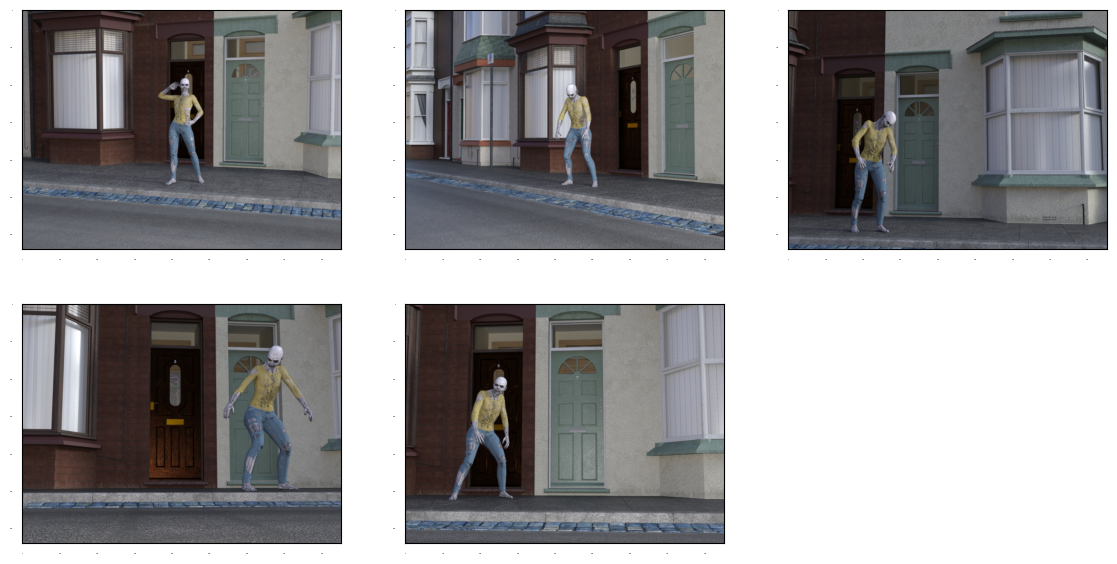

In [5]:
# Load images and visualize
train_image_dir = './training'
train_images_np = []
for i in range(1, 6):
  image_path = os.path.join(train_image_dir, 'training-zombie' + str(i) + '.jpg')
  train_images_np.append(load_image_into_numpy_array(image_path))

plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.labelsize'] = False
plt.rcParams['ytick.labelsize'] = False
plt.rcParams['xtick.top'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['figure.figsize'] = [14, 7]

for idx, train_image_np in enumerate(train_images_np):
  plt.subplot(2, 3, idx+1)
  plt.imshow(train_image_np)
plt.show()

# Annotate images with bounding boxes

In this cell you will annotate the rubber duckies --- draw a box around the rubber ducky in each image; click `next image` to go to the next image and `submit` when there are no more images.

If you'd like to skip the manual annotation step, we totally understand.  In this case, simply skip this cell and run the next cell instead, where we've prepopulated the groundtruth with pre-annotated bounding boxes.



In [6]:
gt_boxes = []
colab_utils.annotate(train_images_np, box_storage_pointer=gt_boxes)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'--boxes array populated--'

<IPython.core.display.Javascript object>

# In case you didn't want to label...

Run this cell only if you didn't annotate anything above and
would prefer to just use our preannotated boxes.  Don't forget
to uncomment.

In [ ]:
gt_boxes = [
            np.array([[0.436, 0.591, 0.629, 0.712]], dtype=np.float32),
            np.array([[0.539, 0.583, 0.73, 0.71]], dtype=np.float32),
            np.array([[0.464, 0.414, 0.626, 0.548]], dtype=np.float32),
            np.array([[0.313, 0.308, 0.648, 0.526]], dtype=np.float32),
            np.array([[0.256, 0.444, 0.484, 0.629]], dtype=np.float32)
]

# Prepare data for training

Below we add the class annotations (for simplicity, we assume a single class in this colab; though it should be straightforward to extend this to handle multiple classes).  We also convert everything to the format that the training
loop below expects (e.g., everything converted to tensors, classes converted to one-hot representations, etc.).

In [7]:

# By convention, our non-background classes start counting at 1.  Given
# that we will be predicting just one class, we will therefore assign it a
# `class id` of 1.
duck_class_id = 1
num_classes = 1

category_index = {duck_class_id: {'id': duck_class_id, 'name': 'zombie'}}

# Convert class labels to one-hot; convert everything to tensors.
# The `label_id_offset` here shifts all classes by a certain number of indices;
# we do this here so that the model receives one-hot labels where non-background
# classes start counting at the zeroth index.  This is ordinarily just handled
# automatically in our training binaries, but we need to reproduce it here.
label_id_offset = 1
train_image_tensors = []
gt_classes_one_hot_tensors = []
gt_box_tensors = []
for (train_image_np, gt_box_np) in zip(
    train_images_np, gt_boxes):
  train_image_tensors.append(tf.expand_dims(tf.convert_to_tensor(
      train_image_np, dtype=tf.float32), axis=0))
  gt_box_tensors.append(tf.convert_to_tensor(gt_box_np, dtype=tf.float32))
  zero_indexed_groundtruth_classes = tf.convert_to_tensor(
      np.ones(shape=[gt_box_np.shape[0]], dtype=np.int32) - label_id_offset)
  gt_classes_one_hot_tensors.append(tf.one_hot(
      zero_indexed_groundtruth_classes, num_classes))
print('Done prepping data.')


Done prepping data.


# Let's just visualize the rubber duckies as a sanity check


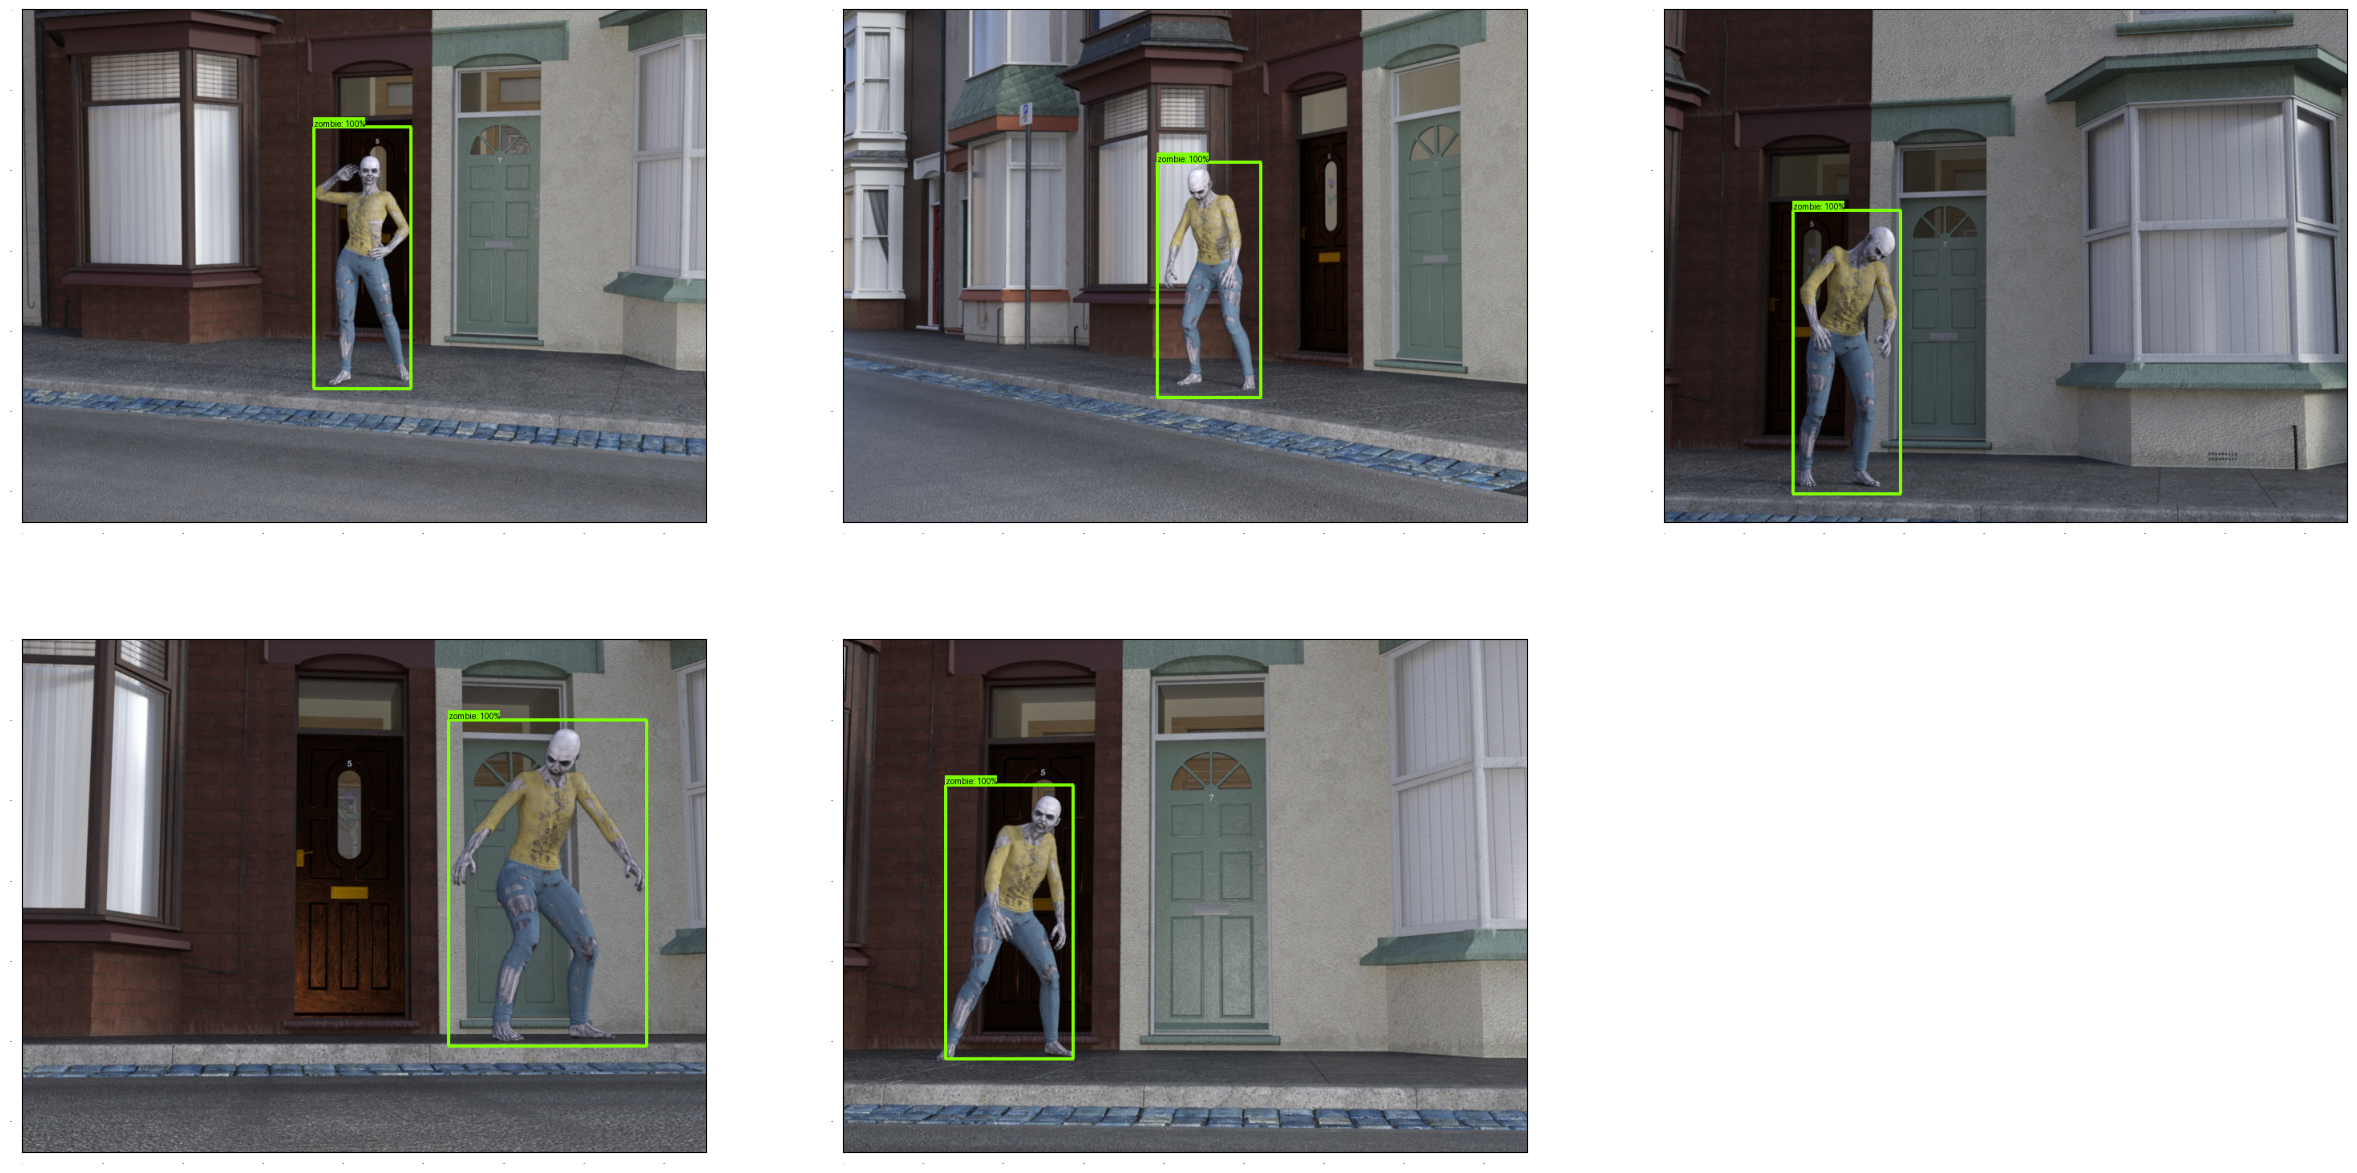

In [8]:
dummy_scores = np.array([1.0], dtype=np.float32)  # give boxes a score of 100%

plt.figure(figsize=(30, 15))
for idx in range(5):
  plt.subplot(2, 3, idx+1)
  plot_detections(
      train_images_np[idx],
      gt_boxes[idx],
      np.ones(shape=[gt_boxes[idx].shape[0]], dtype=np.int32),
      dummy_scores, category_index)
plt.show()

# Create model and restore weights for all but last layer

In this cell we build a single stage detection architecture (RetinaNet) and restore all but the classification layer at the top (which will be automatically randomly initialized).

For simplicity, we have hardcoded a number of things in this colab for the specific RetinaNet architecture at hand (including assuming that the image size will always be 640x640), however it is not difficult to generalize to other model configurations.

In [9]:
# Download the checkpoint and put it into models/research/object_detection/test_data/

!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
!tar -xf ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
!mv ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint models/research/object_detection/test_data/

--2025-03-31 19:07:54--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 142.251.2.207, 142.250.141.207, 74.125.137.207, ...
Connecting to download.tensorflow.org (download.tensorflow.org)|142.251.2.207|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 244817203 (233M) [application/x-tar]
Saving to: ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz’

ssd_resnet50_v1_fpn 100%[===================>] 233.48M  91.7MB/s    in 2.5s    

2025-03-31 19:07:56 (91.7 MB/s) - ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz’ saved [244817203/244817203]



In [10]:
tf.keras.backend.clear_session()

print('Building model and restoring weights for fine-tuning...', flush=True)
num_classes = 1
pipeline_config = 'models/research/object_detection/configs/tf2/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.config'
checkpoint_path = 'models/research/object_detection/test_data/checkpoint/ckpt-0'

# Load pipeline config and build a detection model.
#
# Since we are working off of a COCO architecture which predicts 90
# class slots by default, we override the `num_classes` field here to be just
# one (for our new rubber ducky class).
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
model_config.ssd.num_classes = num_classes
model_config.ssd.freeze_batchnorm = True
detection_model = model_builder.build(
      model_config=model_config, is_training=True)

# Set up object-based checkpoint restore --- RetinaNet has two prediction
# `heads` --- one for classification, the other for box regression.  We will
# restore the box regression head but initialize the classification head
# from scratch (we show the omission below by commenting out the line that
# we would add if we wanted to restore both heads)
fake_box_predictor = tf.compat.v2.train.Checkpoint(
    _base_tower_layers_for_heads=detection_model._box_predictor._base_tower_layers_for_heads,
    # _prediction_heads=detection_model._box_predictor._prediction_heads,
    #    (i.e., the classification head that we *will not* restore)
    _box_prediction_head=detection_model._box_predictor._box_prediction_head,
    )
fake_model = tf.compat.v2.train.Checkpoint(
          _feature_extractor=detection_model._feature_extractor,
          _box_predictor=fake_box_predictor)
ckpt = tf.compat.v2.train.Checkpoint(model=fake_model)
ckpt.restore(checkpoint_path).expect_partial()

# Run model through a dummy image so that variables are created
image, shapes = detection_model.preprocess(tf.zeros([1, 640, 640, 3]))
prediction_dict = detection_model.predict(image, shapes)
_ = detection_model.postprocess(prediction_dict, shapes)
print('Weights restored!')

Building model and restoring weights for fine-tuning...
Weights restored!


# Eager mode custom training loop



In [11]:
tf.keras.backend.set_learning_phase(True)

# These parameters can be tuned; since our training set has 5 images
# it doesn't make sense to have a much larger batch size, though we could
# fit more examples in memory if we wanted to.
batch_size = 4
learning_rate = 0.01
num_batches = 100

# Select variables in top layers to fine-tune.
trainable_variables = detection_model.trainable_variables
to_fine_tune = []
prefixes_to_train = [
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead']
for var in trainable_variables:
  if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
    to_fine_tune.append(var)

# Set up forward + backward pass for a single train step.
def get_model_train_step_function(model, optimizer, vars_to_fine_tune):
  """Get a tf.function for training step."""

  # Use tf.function for a bit of speed.
  # Comment out the tf.function decorator if you want the inside of the
  # function to run eagerly.
  @tf.function
  def train_step_fn(image_tensors,
                    groundtruth_boxes_list,
                    groundtruth_classes_list):
    """A single training iteration.

    Args:
      image_tensors: A list of [1, height, width, 3] Tensor of type tf.float32.
        Note that the height and width can vary across images, as they are
        reshaped within this function to be 640x640.
      groundtruth_boxes_list: A list of Tensors of shape [N_i, 4] with type
        tf.float32 representing groundtruth boxes for each image in the batch.
      groundtruth_classes_list: A list of Tensors of shape [N_i, num_classes]
        with type tf.float32 representing groundtruth boxes for each image in
        the batch.

    Returns:
      A scalar tensor representing the total loss for the input batch.
    """
    shapes = tf.constant(batch_size * [[640, 640, 3]], dtype=tf.int32)
    model.provide_groundtruth(
        groundtruth_boxes_list=groundtruth_boxes_list,
        groundtruth_classes_list=groundtruth_classes_list)
    with tf.GradientTape() as tape:
      preprocessed_images = tf.concat(
          [detection_model.preprocess(image_tensor)[0]
           for image_tensor in image_tensors], axis=0)
      prediction_dict = model.predict(preprocessed_images, shapes)
      losses_dict = model.loss(prediction_dict, shapes)
      total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']
      gradients = tape.gradient(total_loss, vars_to_fine_tune)
      optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))
    return total_loss

  return train_step_fn

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
train_step_fn = get_model_train_step_function(
    detection_model, optimizer, to_fine_tune)

print('Start fine-tuning!', flush=True)
for idx in range(num_batches):
  # Grab keys for a random subset of examples
  all_keys = list(range(len(train_images_np)))
  random.shuffle(all_keys)
  example_keys = all_keys[:batch_size]

  # Note that we do not do data augmentation in this demo.  If you want a
  # a fun exercise, we recommend experimenting with random horizontal flipping
  # and random cropping :)
  gt_boxes_list = [gt_box_tensors[key] for key in example_keys]
  gt_classes_list = [gt_classes_one_hot_tensors[key] for key in example_keys]
  image_tensors = [train_image_tensors[key] for key in example_keys]

  # Training step (forward pass + backwards pass)
  total_loss = train_step_fn(image_tensors, gt_boxes_list, gt_classes_list)

  if idx % 10 == 0:
    print('batch ' + str(idx) + ' of ' + str(num_batches)
    + ', loss=' +  str(total_loss.numpy()), flush=True)

print('Done fine-tuning!')

Start fine-tuning!


/usr/local/lib/python3.11/dist-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


batch 0 of 100, loss=1.202479
batch 10 of 100, loss=2.3757913
batch 20 of 100, loss=0.032504257
batch 30 of 100, loss=0.00489032
batch 40 of 100, loss=0.00198698
batch 50 of 100, loss=0.0011748616
batch 60 of 100, loss=0.0007163947
batch 70 of 100, loss=0.0006227455
batch 80 of 100, loss=0.00052340206
batch 90 of 100, loss=0.0004460634
Done fine-tuning!


In [12]:
# uncomment if you want to delete existing files
!rm zombie-walk-frames.zip
!rm -rf ./zombie-walk
!rm -rf ./results

# download test images
!wget --no-check-certificate \
    https://storage.googleapis.com/tensorflow-3-public/datasets/zombie-walk-frames.zip \
    -O zombie-walk-frames.zip

# unzip test images
local_zip = './zombie-walk-frames.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./results')
zip_ref.close()

rm: cannot remove 'zombie-walk-frames.zip': No such file or directory
--2025-03-31 19:31:40--  https://storage.googleapis.com/tensorflow-3-public/datasets/zombie-walk-frames.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.101.207, 142.251.2.207, 142.250.141.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.101.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94778747 (90M) [application/zip]
Saving to: ‘zombie-walk-frames.zip’

zombie-walk-frames. 100%[===================>]  90.39M   101MB/s    in 0.9s    

2025-03-31 19:31:42 (101 MB/s) - ‘zombie-walk-frames.zip’ saved [94778747/94778747]



In [13]:
test_image_dir = './results/'
test_images_np = []

# load images into a numpy array. this will take a few minutes to complete.
for i in range(0, 237):
    image_path = os.path.join(test_image_dir, 'zombie-walk' + "{0:04}".format(i) + '.jpg')
    print(image_path)
    test_images_np.append(np.expand_dims(
      load_image_into_numpy_array(image_path), axis=0))

./results/zombie-walk0000.jpg
./results/zombie-walk0001.jpg
./results/zombie-walk0002.jpg
./results/zombie-walk0003.jpg
./results/zombie-walk0004.jpg
./results/zombie-walk0005.jpg
./results/zombie-walk0006.jpg
./results/zombie-walk0007.jpg
./results/zombie-walk0008.jpg
./results/zombie-walk0009.jpg
./results/zombie-walk0010.jpg
./results/zombie-walk0011.jpg
./results/zombie-walk0012.jpg
./results/zombie-walk0013.jpg
./results/zombie-walk0014.jpg
./results/zombie-walk0015.jpg
./results/zombie-walk0016.jpg
./results/zombie-walk0017.jpg
./results/zombie-walk0018.jpg
./results/zombie-walk0019.jpg
./results/zombie-walk0020.jpg
./results/zombie-walk0021.jpg
./results/zombie-walk0022.jpg
./results/zombie-walk0023.jpg
./results/zombie-walk0024.jpg
./results/zombie-walk0025.jpg
./results/zombie-walk0026.jpg
./results/zombie-walk0027.jpg
./results/zombie-walk0028.jpg
./results/zombie-walk0029.jpg
./results/zombie-walk0030.jpg
./results/zombie-walk0031.jpg
./results/zombie-walk0032.jpg
./results/

In [16]:
# Again, uncomment this decorator if you want to run inference eagerly
@tf.function
def detect(input_tensor):
    """Run detection on an input image.

    Args:
    input_tensor: A [1, height, width, 3] Tensor of type tf.float32.
      Note that height and width can be anything since the image will be
      immediately resized according to the needs of the model within this
      function.

    Returns:
    A dict containing 3 Tensors (`detection_boxes`, `detection_classes`,
      and `detection_scores`).
    """
    preprocessed_image, shapes = detection_model.preprocess(input_tensor)
    prediction_dict = detection_model.predict(preprocessed_image, shapes)

    ### START CODE HERE (Replace instances of `None` with your code) ###
    # use the detection model's postprocess() method to get the the final detections
    detections = detection_model.postprocess(prediction_dict,shapes)
    ### END CODE HERE ###

    return detections

In [17]:
# Note that the first frame will trigger tracing of the tf.function, which will
# take some time, after which inference should be fast.

label_id_offset = 1
results = {'boxes': [], 'scores': []}

for i in range(len(test_images_np)):
    input_tensor = tf.convert_to_tensor(test_images_np[i], dtype=tf.float32)
    detections = detect(input_tensor)
    plot_detections(
      test_images_np[i][0],
      detections['detection_boxes'][0].numpy(),
      detections['detection_classes'][0].numpy().astype(np.uint32)
      + label_id_offset,
      detections['detection_scores'][0].numpy(),
      category_index, figsize=(15, 20), image_name="./results/gif_frame_" + ('%03d' % i) + ".jpg")
    results['boxes'].append(detections['detection_boxes'][0][0].numpy())
    results['scores'].append(detections['detection_scores'][0][0].numpy())

In [18]:
# TEST CODE

print(len(results['boxes']))
print(results['boxes'][0].shape)
print()

# compare with expected bounding boxes
print(np.allclose(results['boxes'][0], [0.28838485, 0.06830047, 0.7213766 , 0.19833465], rtol=0.18))
print(np.allclose(results['boxes'][5], [0.29168868, 0.07529271, 0.72504973, 0.20099735], rtol=0.18))
print(np.allclose(results['boxes'][10], [0.29548776, 0.07994056, 0.7238164 , 0.20778716], rtol=0.18))

237
(4,)

True
True
True


In [19]:
x = np.array(results['scores'])

# percent of frames where a zombie is detected
zombie_detected = (np.where(x > 0.9, 1, 0).sum())/237*100
print(zombie_detected)

90.71729957805907


Frame 0


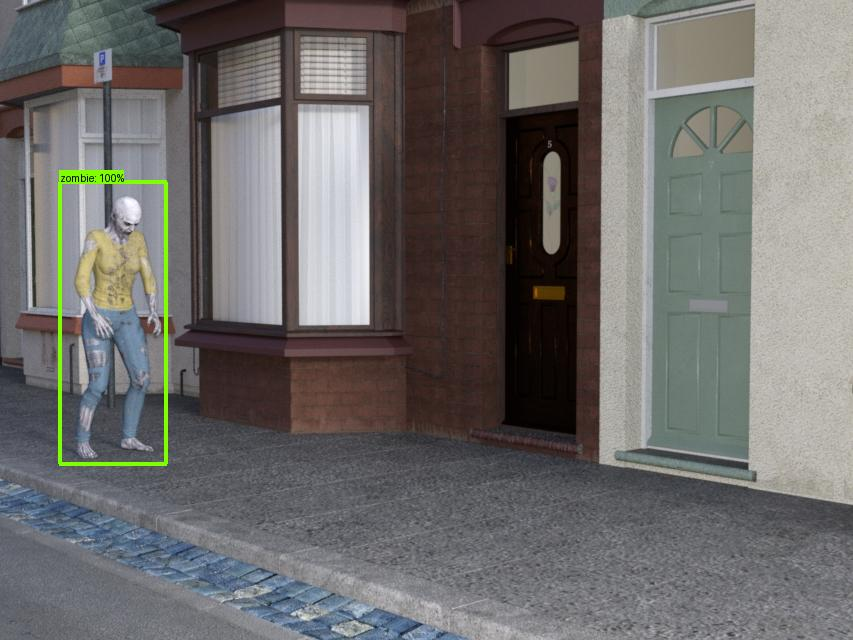


Frame 5


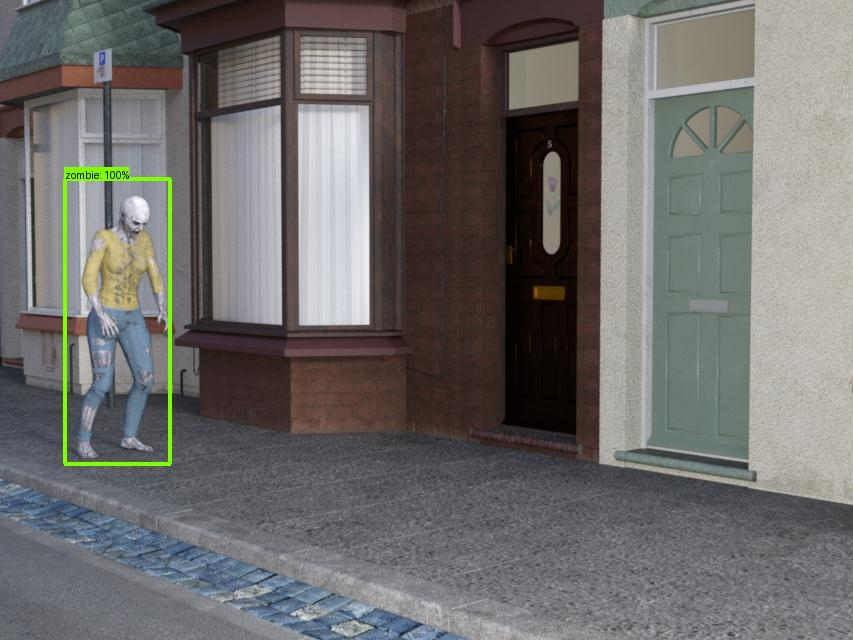


Frame 10


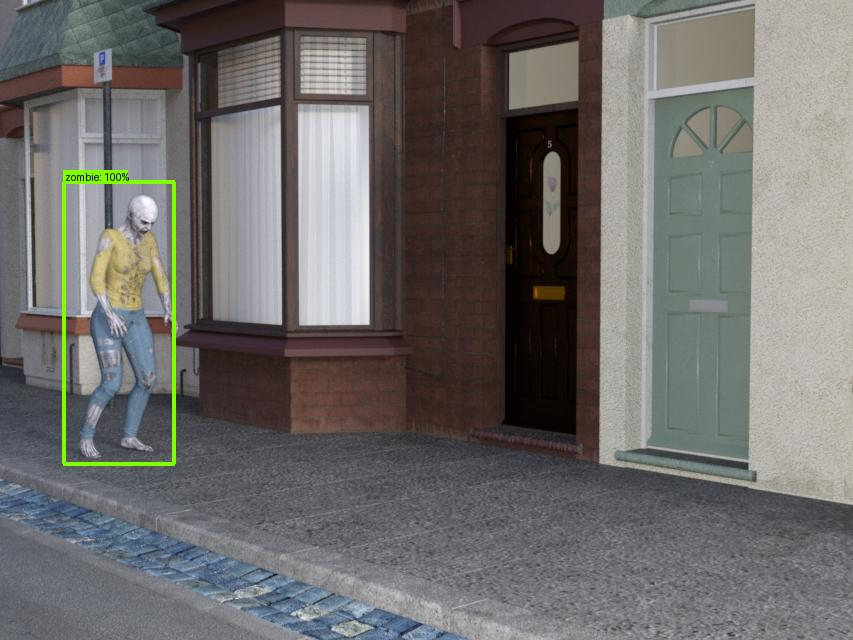

In [20]:
print('Frame 0')
display(IPyImage('./results/gif_frame_000.jpg'))
print()
print('Frame 5')
display(IPyImage('./results/gif_frame_005.jpg'))
print()
print('Frame 10')
display(IPyImage('./results/gif_frame_010.jpg'))

In [21]:
zipf = zipfile.ZipFile('./zombie.zip', 'w', zipfile.ZIP_DEFLATED)

filenames = glob.glob('./results/gif_frame_*.jpg')
filenames = sorted(filenames)

for filename in filenames:
    zipf.write(filename)

zipf.close()

In [ ]:
imageio.plugins.freeimage.download()

!rm -rf ./results/zombie-anim.gif

anim_file = './zombie-anim.gif'

filenames = glob.glob('./results/gif_frame_*.jpg')
filenames = sorted(filenames)
last = -1
images = []

for filename in filenames:
    image = imageio.imread(filename)
    images.append(image)

imageio.mimsave(anim_file, images, 'GIF-FI', fps=10)

In [22]:
import pickle

# remove file if it exists
!rm results.data

# write results to binary file. upload for grading.
with open('results.data', 'wb') as filehandle:
    pickle.dump(results['boxes'], filehandle)

print('Done saving! Please download `results.data` from the Files tab\n' \
      'on the left and submit for grading.\nYou can also use the next cell as a shortcut for downloading.')

rm: cannot remove 'results.data': No such file or directory
Done saving! Please download `results.data` from the Files tab
on the left and submit for grading.
You can also use the next cell as a shortcut for downloading.


In [23]:
from google.colab import files

files.download('results.data')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Load test images and run inference with new model!

In [ ]:
test_image_dir = 'models/research/object_detection/test_images/ducky/test/'
test_images_np = []
for i in range(1, 50):
  image_path = os.path.join(test_image_dir, 'out' + str(i) + '.jpg')
  test_images_np.append(np.expand_dims(
      load_image_into_numpy_array(image_path), axis=0))

# Again, uncomment this decorator if you want to run inference eagerly
@tf.function
def detect(input_tensor):
  """Run detection on an input image.

  Args:
    input_tensor: A [1, height, width, 3] Tensor of type tf.float32.
      Note that height and width can be anything since the image will be
      immediately resized according to the needs of the model within this
      function.

  Returns:
    A dict containing 3 Tensors (`detection_boxes`, `detection_classes`,
      and `detection_scores`).
  """
  preprocessed_image, shapes = detection_model.preprocess(input_tensor)
  prediction_dict = detection_model.predict(preprocessed_image, shapes)
  return detection_model.postprocess(prediction_dict, shapes)

# Note that the first frame will trigger tracing of the tf.function, which will
# take some time, after which inference should be fast.

label_id_offset = 1
for i in range(len(test_images_np)):
  input_tensor = tf.convert_to_tensor(test_images_np[i], dtype=tf.float32)
  detections = detect(input_tensor)

  plot_detections(
      test_images_np[i][0],
      detections['detection_boxes'][0].numpy(),
      detections['detection_classes'][0].numpy().astype(np.uint32)
      + label_id_offset,
      detections['detection_scores'][0].numpy(),
      category_index, figsize=(15, 20), image_name="gif_frame_" + ('%02d' % i) + ".jpg")

In [ ]:
imageio.plugins.freeimage.download()

anim_file = 'duckies_test.gif'

filenames = glob.glob('gif_frame_*.jpg')
filenames = sorted(filenames)
last = -1
images = []
for filename in filenames:
  image = imageio.imread(filename)
  images.append(image)

imageio.mimsave(anim_file, images, 'GIF-FI', fps=5)

display(IPyImage(open(anim_file, 'rb').read()))